In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: False


In [2]:
 !pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.9 MB/s eta 0:00:00


In [3]:
import pickle
import snntorch as snn
import snntorch.spikeplot as splt
import snntorch.spikegen as spk
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


**Working with dataset5.pkl**

In [2]:
# np.random.seed(42)

#load dataset
with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset5.pkl", "rb") as f:
    data = pickle.load(f)

#split data into test and train
indexes = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_indexes = indexes[:train_size]
test_indexes = indexes[train_size:]

train_data = [data[i] for i in train_indexes]
test_data = [data[i] for i in test_indexes]

print(f"training data size {len(train_data)}")
print(f"test data size {len(test_data)}")

#create CustomDataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.y = []
        self.x = []
        self.labels = []
        # self.tau = []

        #process each sample
        for sample in data:
            y = sample[0]
            x = sample[1]
            label = sample[2]
            # tau = sample[3]

            self.y.append(y)
            self.x.append(x)
            self.labels.append(label)
            # self.tau.append(tau)


        self.y = torch.tensor(self.y, dtype = torch.float32)
        self.x = torch.tensor(self.x, dtype= torch.float32)
        self.labels = torch.tensor(self.labels, dtype= torch.long)
        # self.tau = torch.tensor(self.tau, dtype= torch.float32)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, index):
        return self.y[index], self.x[index], self.labels[index] #, self.tau[index]

#create train and test dataset
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

#create dataloader
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True, drop_last= True)


import pandas as pd
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

for y, x, v in train_loader:
    print(f"Batch y shape: {y.shape}")
    print(f"Batch x shape: {x.shape}")
    print(f"Batch labels shape: {v.shape}")
    break

    break  # Just check the first batch


training data size 80000
test data size 20000


<ipython-input-2-1cfde38e8c9b>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.y = torch.tensor(self.y, dtype = torch.float32)


Class distribution in the original training dataset: 0    40018
1    39982
Name: count, dtype: int64
Class distribution in the original testing dataset: 0    10050
1     9950
Name: count, dtype: int64
Batch y shape: torch.Size([128, 80, 16])
Batch x shape: torch.Size([128, 80, 16])
Batch labels shape: torch.Size([128])


In [3]:
#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem2_rec = []
        spk2_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


In [4]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_metrics(y_true, y_pred_probs, threshold= num_steps / 2):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).float()

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ✅ Precision, Recall, F1
    precision = precision_score(y_true.cpu(), y_pred.cpu())
    recall = recall_score(y_true.cpu(), y_pred.cpu())
    f1 = f1_score(y_true.cpu(), y_pred.cpu())

    # ✅ ROC-AUC Score
    auc = roc_auc_score(y_true.cpu(), y_pred_probs.cpu())

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

    # ✅ Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_pred_probs.cpu())
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


Epoch 1/5 - Evaluation Metrics_Trainingran:


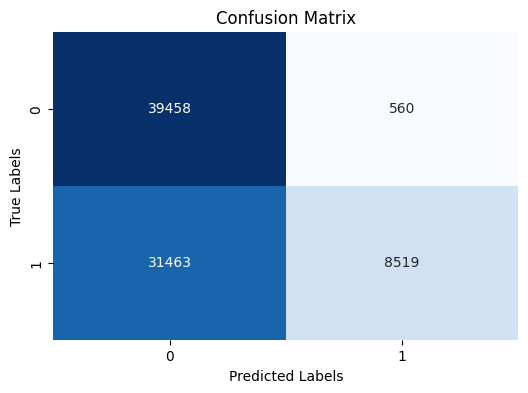

Precision: 0.9383
Recall: 0.2131
F1 Score: 0.3473
ROC-AUC Score: 0.6934


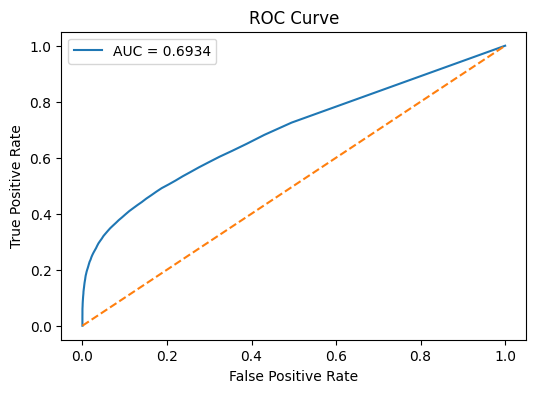

Epoch 1, Iteration 625
Train Set Loss: 52.167
Test Set Loss: 52.365
Train Set Accuracy: 59.9712
Test Set Accuracy: 59.4425



Epoch 2/5 - Evaluation Metrics_Trainingran:


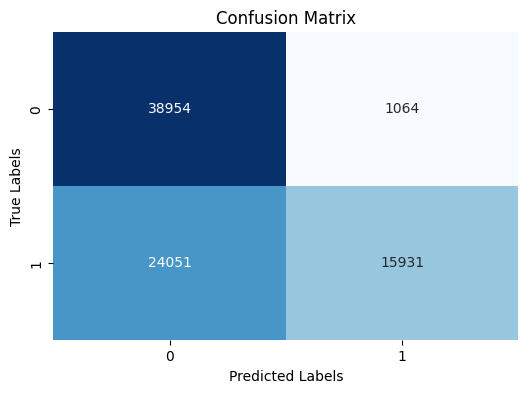

Precision: 0.9374
Recall: 0.3985
F1 Score: 0.5592
ROC-AUC Score: 0.7910


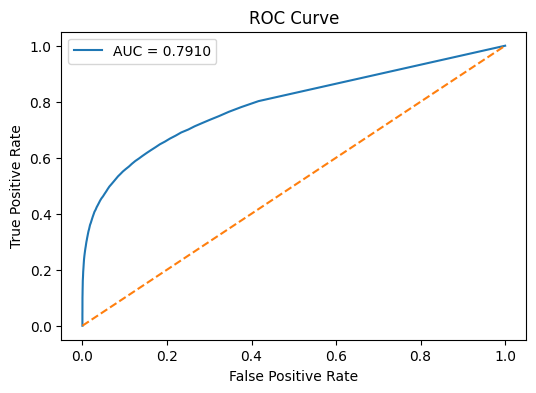

Epoch 2, Iteration 625
Train Set Loss: 47.260
Test Set Loss: 47.413
Train Set Accuracy: 68.6063
Test Set Accuracy: 68.4100



Epoch 3/5 - Evaluation Metrics_Trainingran:


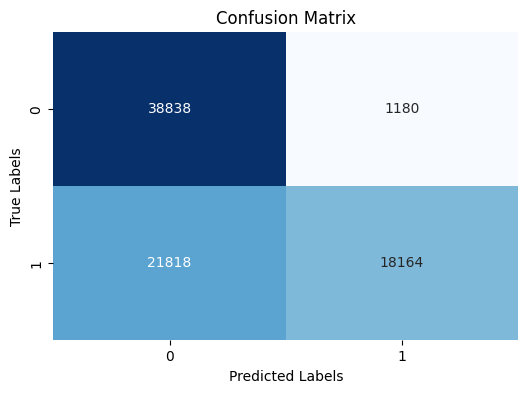

Precision: 0.9390
Recall: 0.4543
F1 Score: 0.6123
ROC-AUC Score: 0.8072


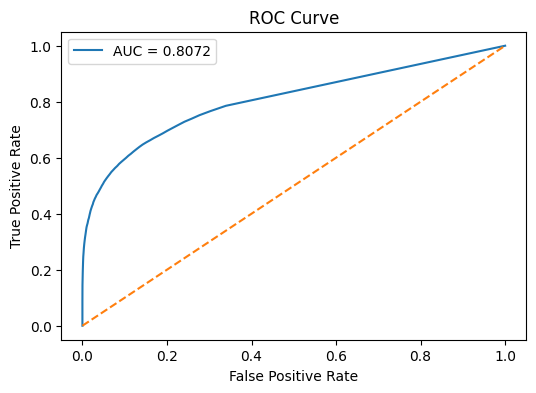

Epoch 3, Iteration 625
Train Set Loss: 44.942
Test Set Loss: 44.895
Train Set Accuracy: 71.2525
Test Set Accuracy: 71.1475



Epoch 4/5 - Evaluation Metrics_Trainingran:


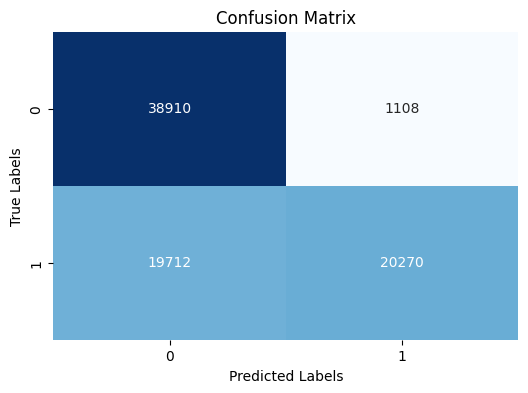

Precision: 0.9482
Recall: 0.5070
F1 Score: 0.6607
ROC-AUC Score: 0.8339


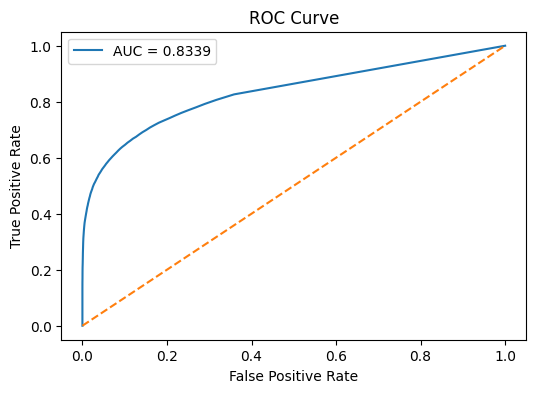

Epoch 4, Iteration 625
Train Set Loss: 42.855
Test Set Loss: 43.455
Train Set Accuracy: 73.9750
Test Set Accuracy: 73.7537



Epoch 5/5 - Evaluation Metrics_Trainingran:


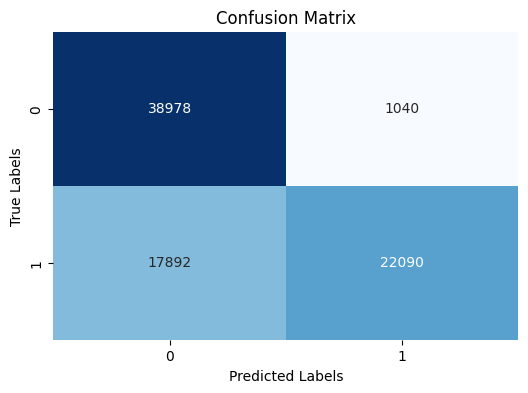

Precision: 0.9550
Recall: 0.5525
F1 Score: 0.7000
ROC-AUC Score: 0.8541


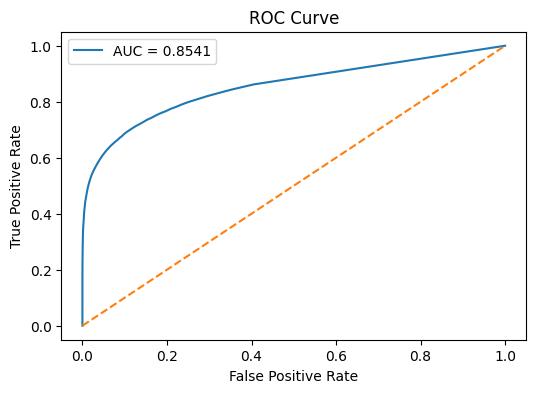

Epoch 5, Iteration 625
Train Set Loss: 41.684
Test Set Loss: 41.737
Train Set Accuracy: 76.3350
Test Set Accuracy: 76.5413


Total time: 65.33794196049372 min.


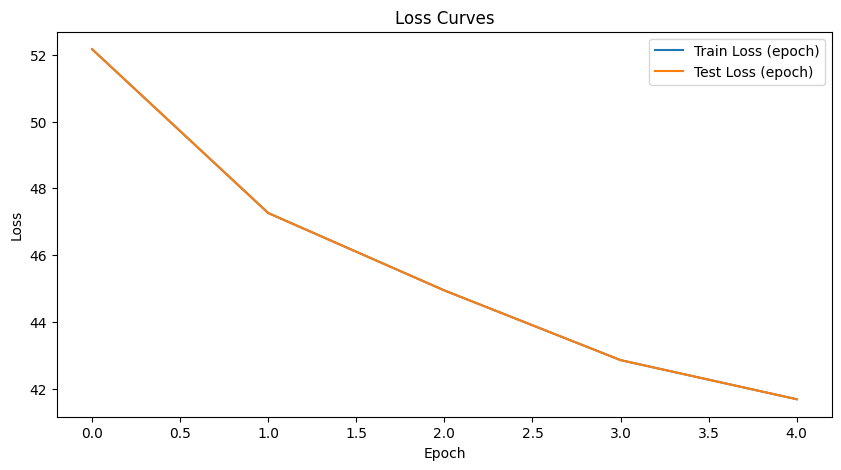

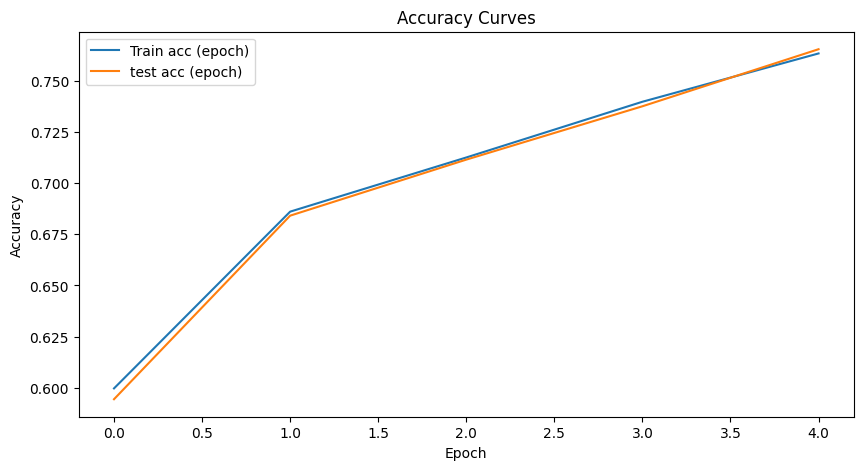

In [5]:
from snntorch import functional as SF

def print_batch_accuracy(dataY, dataX, targets, train=False):
    output, _ = net(dataY, dataX)  #[80, 128, 1]

    pred = (output.sum(dim=0) > num_steps / 2).float()
    acc = (pred == targets).float().mean().item()

    if train:

        # Collect Predictions
        class_output = output.sum(dim=0)
        all_preds.extend(class_output.squeeze().cpu().numpy())
        all_targets.extend(targets.squeeze().cpu().numpy())

        # print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    # else:
        # print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    return acc



def epoch_printer():

    train_avg_acc.append(sum(train_acc)/len(train_acc))
    test_avg_acc.append(sum(test_acc)/len(test_acc))
    train_avg_loss.append(sum(loss_hist)/len(loss_hist))
    test_avg_loss.append(sum(test_loss_hist)/len(test_loss_hist))

    print(f"Epoch {epoch+1}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_avg_loss[-1]:.3f}")
    print(f"Test Set Loss: {test_avg_loss[-1]:.3f}")
    print(f"Train Set Accuracy: {train_avg_acc[-1]* 100:.4f}")
    print(f"Test Set Accuracy: {test_avg_acc[-1]* 100:.4f}")
    print("\n")



loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=1e-4)


#Train loop
num_epochs = 5
counter = 0
train_avg_acc=[]
test_avg_acc=[]
train_avg_loss=[]
test_avg_loss=[]


start = time.time()
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader) #625 * 128 = 80000
    # test_batch = iter(test_loader)

    loss_hist = []
    test_loss_hist = []
    all_preds = []
    all_targets = []
    train_acc = []
    test_acc = []

    # Minibatch training loop
    for y, x, targets in train_batch:
        y = y.to(device)
        x = x.to(device)
        y = y.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        targets = targets.to(device)
        targets2 = targets.float().unsqueeze(1) # add a new dimension because the shape of targets should matche the shape of model output, ([batch_size, 1])

        # forward pass
        net.train()
        spk_class, mem_class = net(y, x)    # mem_class.shape torch.Size([80, 128, 1])
        # print(f"Shape spk.shape:{spk_rec.shape}, mem.shape:{mem_class.shape}")


        # initialize the loss & sum it
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_class[step], targets2) #mem_class[step].shape = [128,1], target.shape = (128,1)


        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        # Store loss history for future plotting
        loss_hist.append(loss_val.item())



        # Test set
        with torch.no_grad():
            net.eval()
            # try:
            #   test_y, test_x, test_targets = next(test_batch)  # Get the next test batch
            # except StopIteration:
            #   test_batch = iter(test_loader)  # Reset the test loader when it runs out
            #   test_y, test_x, test_targets = next(test_batch)

            test_y, test_x, test_targets = next(iter(test_loader))
            test_y = test_y.to(device).permute(1, 0, 2)
            test_x = test_x.to(device).permute(1, 0, 2)
            test_targets = test_targets.to(device)
            test_targets2 = test_targets.float().unsqueeze(1)

            # Test set forward pass
            test_spk, test_mem = net(test_y, test_x)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              test_loss += loss(test_mem[step], test_targets2)


            test_loss_hist.append(test_loss.item())

            #Calculate accuracy
            train_acc.append(print_batch_accuracy(y, x, targets2, train=True))
            test_acc.append(print_batch_accuracy(test_y, test_x, test_targets2, train=False))


            counter += 1
            iter_counter +=1



    # Compute Overall Test Metrics
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Evaluation Metrics_Trainingran:")
    calculate_metrics(all_targets, all_preds)

    epoch_printer()




end= time.time()
print(f"Total time: {(end-start)/60} min.")

# Plot Loss for Train and Test for Each Epoch
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(range(len(train_avg_loss)), train_avg_loss, label='Train Loss (epoch)')
plt.plot(range(len(train_avg_loss)), train_avg_loss, label='Test Loss (epoch)')
plt.title("Loss Curves")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot acc
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_avg_acc, label='Train acc (epoch)')
plt.plot(test_avg_acc, label='test acc (epoch)')
plt.title("Accuracy Curves")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


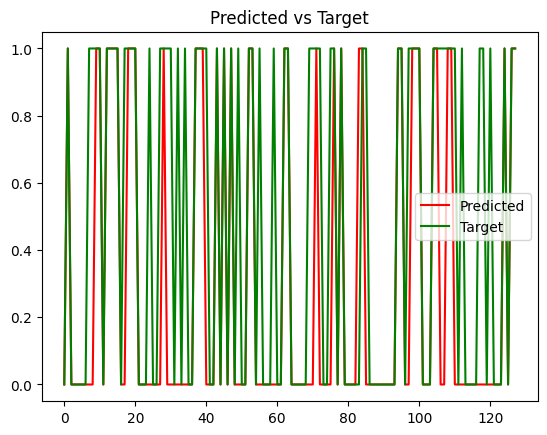

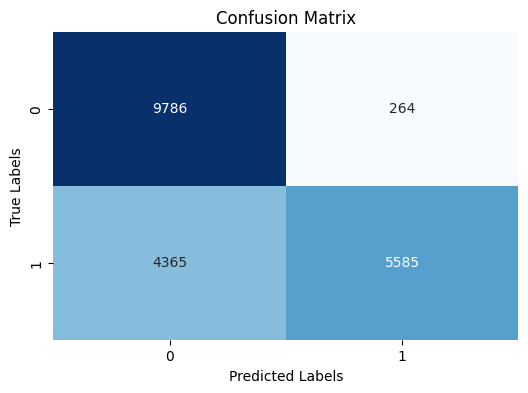

Precision: 0.9549
Recall: 0.5613
F1 Score: 0.7070
ROC-AUC Score: 0.8582


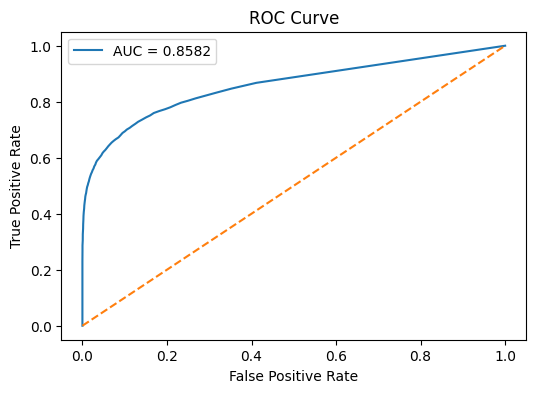

Total size: 20000, Correct_Prediction: 15371.0
Test Set Accuracy: 76.855%, acc : 76.82%
Average Test Loss: 41.6835


In [14]:
#Test the model with dataset5------------------------------
total = 0
correct = 0
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
total_loss=0
i=0
all_preds=[]
all_targets=[]
accList=[]

with torch.no_grad():
  net.eval()
  for y_t, x_t, target_t in test_loader:
    y_t = y_t.to(device).permute(1, 0, 2)
    x_t = x_t.to(device).permute(1, 0, 2)
    target_t = target_t.to(device)
    targets = target_t.to(device).float().unsqueeze(1)

    test_spk, test_mem = net(y_t, x_t)  # forward pass

    # Calculate loss
    batch_loss = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      batch_loss += loss(test_mem[step], targets)
    total_loss += batch_loss.item()

    # Calculate accuracy
    predicted = (test_spk.sum(dim=0) > num_steps / 2).float()
    acc = (predicted == targets).float().mean().item()
    correct += (predicted == targets).float().sum().item()
    total += targets.size(0)

    classOutput = test_spk.sum(dim=0)
    all_preds.extend(classOutput.squeeze().cpu().numpy())
    all_targets.extend(targets.squeeze().cpu().numpy())

    accList.append(acc)

    i+=1
    if i == 1:
      plt.plot(predicted, label='Predicted', color='red')
      plt.plot(targets, label='Target', color='green')
      plt.title('Predicted vs Target')
      plt.legend()
      plt.show()

# Compute Overall Test Metrics
all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)
calculate_metrics(all_targets, all_preds)


print(f"Total size: {total}, Correct_Prediction: {correct}")
print(f"Test Set Accuracy: {100 * correct / total}%, acc : {(sum(accList)/ len(accList)) * 100:.2f}%")
print(f"Average Test Loss: {total_loss / len(test_loader):.4f}")





**Working with dataset5_Tau.pkl**


In [4]:
# np.random.seed(42)

#load dataset
with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset5_Tau.pkl", "rb") as f:
    data = pickle.load(f)

#split data into test and train
indexes = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_indexes = indexes[:train_size]
test_indexes = indexes[train_size:]

train_data = [data[i] for i in train_indexes]
test_data = [data[i] for i in test_indexes]

print(f"training data size {len(train_data)}")
print(f"test data size {len(test_data)}")

#create CustomDataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.y = []
        self.x = []
        self.labels = []
        self.tau = []

        #process each sample
        for sample in data:
            y = sample[0]
            x = sample[1]
            label = sample[2]
            tau = sample[3]

            self.y.append(y)
            self.x.append(x)
            self.labels.append(label)
            self.tau.append(tau)


        self.y = torch.tensor(self.y, dtype = torch.float32)
        self.x = torch.tensor(self.x, dtype= torch.float32)
        self.labels = torch.tensor(self.labels, dtype= torch.long)
        self.tau = torch.tensor(self.tau, dtype= torch.float32)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, index):
        return self.y[index], self.x[index], self.labels[index], self.tau[index]

#create train and test dataset
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

#create dataloader
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True, drop_last= True)


import pandas as pd
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

for y, x, v, tau in train_loader:
    print(f"Batch y shape: {y.shape}")
    print(f"Batch x shape: {x.shape}")
    print(f"Batch labels shape: {v.shape}")
    print(f"Batch tau shape: {tau.shape}")
    break

    break  # Just check the first batch


training data size 80000
test data size 20000


<ipython-input-4-8d682fbf3969>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.y = torch.tensor(self.y, dtype = torch.float32)


Class distribution in the original training dataset: 0    40022
1    39978
Name: count, dtype: int64
Class distribution in the original testing dataset: 0    10046
1     9954
Name: count, dtype: int64
Batch y shape: torch.Size([128, 80, 16])
Batch x shape: torch.Size([128, 80, 16])
Batch labels shape: torch.Size([128])
Batch tau shape: torch.Size([128])


In [5]:
#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem2_rec = []
        spk2_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_metrics(y_true, y_pred_probs, threshold= num_steps / 2):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).float()

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ✅ Precision, Recall, F1
    precision = precision_score(y_true.cpu(), y_pred.cpu())
    recall = recall_score(y_true.cpu(), y_pred.cpu())
    f1 = f1_score(y_true.cpu(), y_pred.cpu())

    # ✅ ROC-AUC Score
    auc = roc_auc_score(y_true.cpu(), y_pred_probs.cpu())

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

    # ✅ Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_pred_probs.cpu())
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


Epoch 1/5 - Evaluation Metrics_Trainingran:


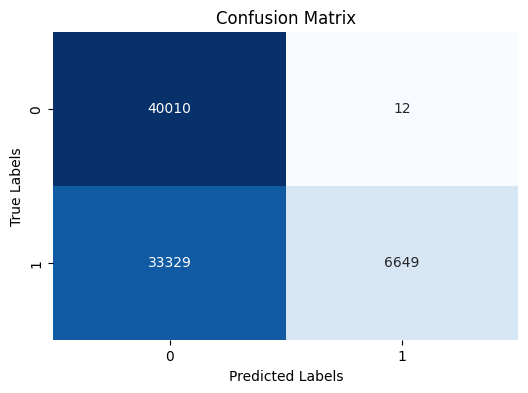

Precision: 0.9982
Recall: 0.1663
F1 Score: 0.2851
ROC-AUC Score: 0.6627


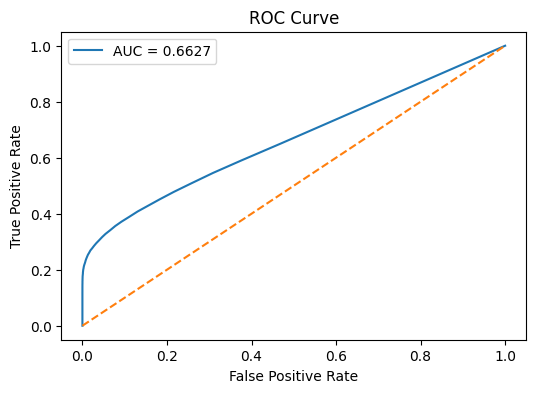

Epoch 1, Iteration 625
Train Set Loss: 51.272
Test Set Loss: 51.370
Train Set Accuracy: 58.3237
Test Set Accuracy: 58.5450



Epoch 2/5 - Evaluation Metrics_Trainingran:


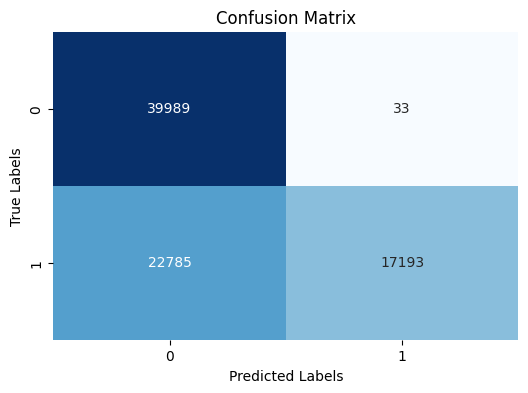

Precision: 0.9981
Recall: 0.4301
F1 Score: 0.6011
ROC-AUC Score: 0.8105


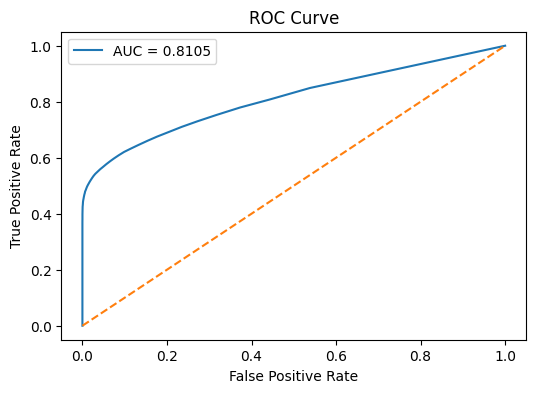

Epoch 2, Iteration 625
Train Set Loss: 43.997
Test Set Loss: 44.033
Train Set Accuracy: 71.4775
Test Set Accuracy: 71.8725



Epoch 3/5 - Evaluation Metrics_Trainingran:


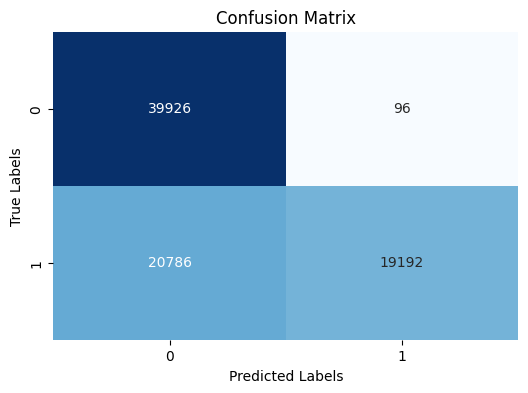

Precision: 0.9950
Recall: 0.4801
F1 Score: 0.6477
ROC-AUC Score: 0.8165


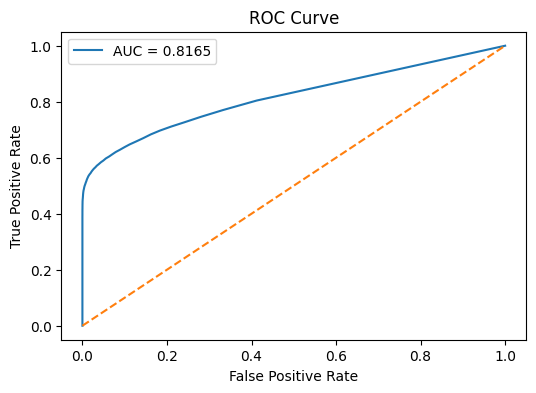

Epoch 3, Iteration 625
Train Set Loss: 41.524
Test Set Loss: 41.537
Train Set Accuracy: 73.8975
Test Set Accuracy: 74.1012



Epoch 4/5 - Evaluation Metrics_Trainingran:


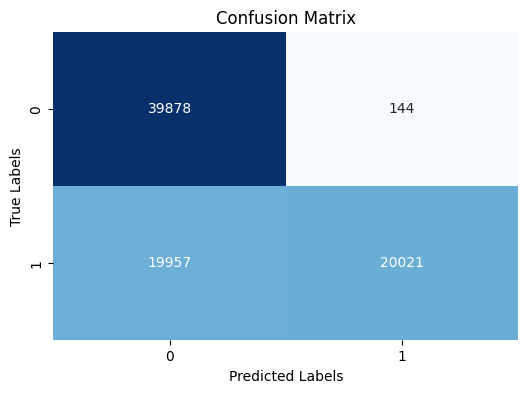

Precision: 0.9929
Recall: 0.5008
F1 Score: 0.6658
ROC-AUC Score: 0.8146


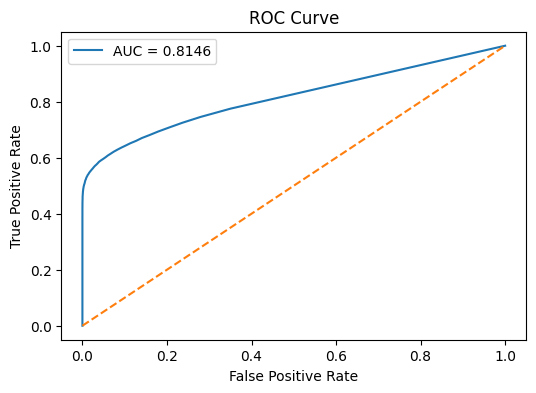

Epoch 4, Iteration 625
Train Set Loss: 40.356
Test Set Loss: 40.648
Train Set Accuracy: 74.8738
Test Set Accuracy: 74.7837



Epoch 5/5 - Evaluation Metrics_Trainingran:


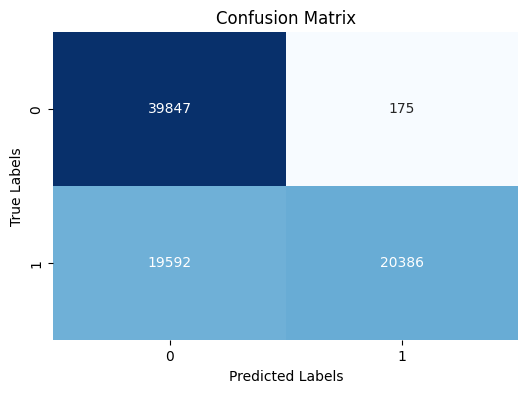

Precision: 0.9915
Recall: 0.5099
F1 Score: 0.6735
ROC-AUC Score: 0.8141


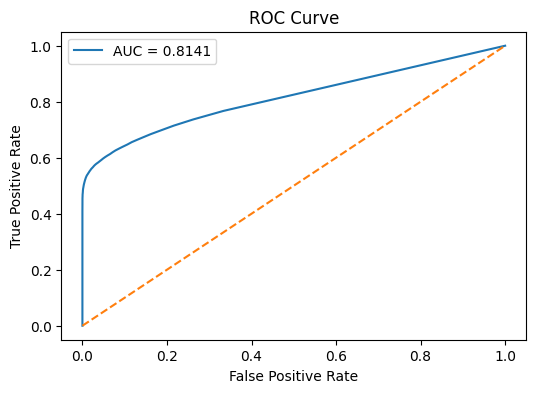

Epoch 5, Iteration 625
Train Set Loss: 39.779
Test Set Loss: 40.029
Train Set Accuracy: 75.2913
Test Set Accuracy: 75.3025


Total time: 64.6148739139239 min.


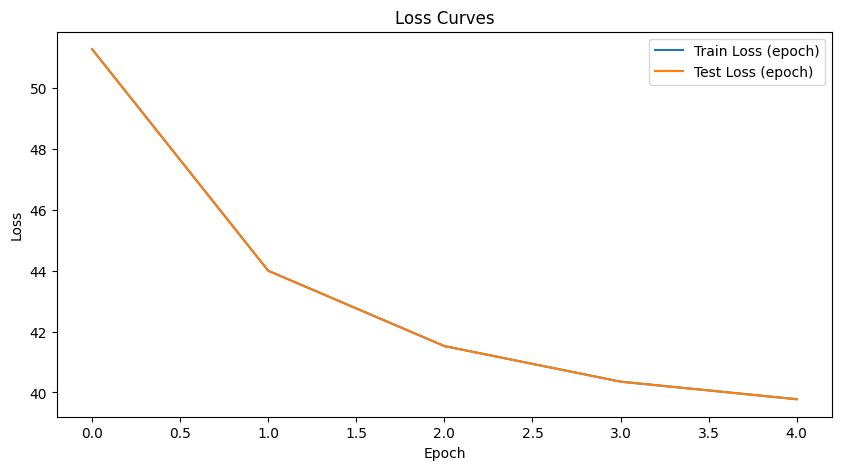

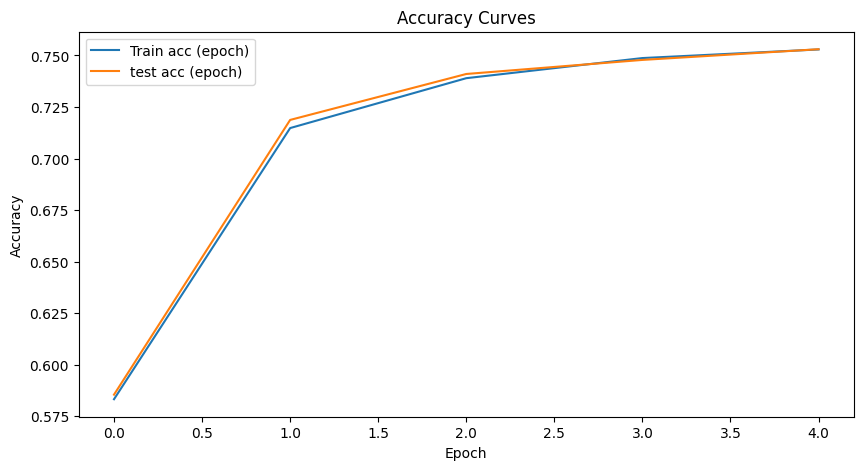

In [7]:
from snntorch import functional as SF

def print_batch_accuracy(dataY, dataX, targets, train=False):
    output, _ = net(dataY, dataX)  #[80, 128, 1]

    pred = (output.sum(dim=0) > num_steps / 2).float()
    acc = (pred == targets).float().mean().item()

    if train:
        # Collect Predictions
        class_output = output.sum(dim=0)
        all_preds.extend(class_output.squeeze().cpu().numpy())
        all_targets.extend(targets.squeeze().cpu().numpy())
        # print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    # else:
        # print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    return acc



def epoch_printer():

    train_avg_acc.append(sum(train_acc)/len(train_acc))
    test_avg_acc.append(sum(test_acc)/len(test_acc))
    train_avg_loss.append(sum(loss_hist)/len(loss_hist))
    test_avg_loss.append(sum(test_loss_hist)/len(test_loss_hist))

    print(f"Epoch {epoch+1}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_avg_loss[-1]:.3f}")
    print(f"Test Set Loss: {test_avg_loss[-1]:.3f}")
    print(f"Train Set Accuracy: {train_avg_acc[-1]* 100:.4f}")
    print(f"Test Set Accuracy: {test_avg_acc[-1]* 100:.4f}")
    # print_batch_accuracy(y, x, targets2, train=True)
    # print_batch_accuracy(test_y, test_x, test_targets2, train=False)
    print("\n")





loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=1e-4)


#Train loop
num_epochs = 5
counter = 0
train_avg_acc=[]
test_avg_acc=[]
train_avg_loss=[]
test_avg_loss=[]


start = time.time()
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader) #625 * 128 = 80000
    # test_batch = iter(test_loader)

    loss_hist = []
    test_loss_hist = []
    all_preds = []
    all_targets = []
    train_acc = []
    test_acc = []

    # Minibatch training loop
    for y, x, targets, tau in train_batch:
        y = y.to(device)
        x = x.to(device)
        y = y.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        targets = targets.to(device)
        targets2 = targets.float().unsqueeze(1) # add a new dimension because the shape of targets should matche the shape of model output, ([batch_size, 1])

        # forward pass
        net.train()
        spk_class, mem_class = net(y, x)    # mem_class.shape torch.Size([80, 128, 1])
        # print(f"Shape spk.shape:{spk_rec.shape}, mem.shape:{mem_class.shape}")


        # initialize the loss & sum it
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_class[step], targets2) #mem_class[step].shape = [128,1], target.shape = (128,1)
        # loss_val /= num_steps  # Normalize by number of time steps

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()


        # Store loss history for future plotting
        loss_hist.append(loss_val.item())



        # Test set
        with torch.no_grad():
            net.eval()
            # try:
            #   test_y, test_x, test_targets,tau = next(test_batch)  # Get the next test batch
            # except StopIteration:
            #   test_batch = iter(test_loader)  # Reset the test loader when it runs out
            #   test_y, test_x, test_targets, tau = next(test_batch)

            test_y, test_x, test_targets, tau = next(iter(test_loader))
            test_y = test_y.to(device).permute(1, 0, 2)
            test_x = test_x.to(device).permute(1, 0, 2)
            test_targets = test_targets.to(device)
            test_targets2 = test_targets.float().unsqueeze(1)

            # Test set forward pass
            test_spk, test_mem = net(test_y, test_x)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              test_loss += loss(test_mem[step], test_targets2)
            # test_loss /= num_steps  # Normalize by number of time steps

            test_loss_hist.append(test_loss.item())

            #Calculate accuracy
            train_acc.append(print_batch_accuracy(y, x, targets2, train=True))
            test_acc.append(print_batch_accuracy(test_y, test_x, test_targets2, train=False))


            counter += 1
            iter_counter +=1



    # Compute Overall Test Metrics
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Evaluation Metrics_Trainingran:")
    calculate_metrics(all_targets, all_preds)

    epoch_printer()




end= time.time()
print(f"Total time: {(end-start)/60} min.")

# Plot Loss for Train and Test for Each Epoch
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(range(len(train_avg_loss)), train_avg_loss, label='Train Loss (epoch)')
plt.plot(range(len(train_avg_loss)), train_avg_loss, label='Test Loss (epoch)')
plt.title("Loss Curves")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot acc
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_avg_acc, label='Train acc (epoch)')
plt.plot(test_avg_acc, label='test acc (epoch)')
plt.title("Accuracy Curves")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


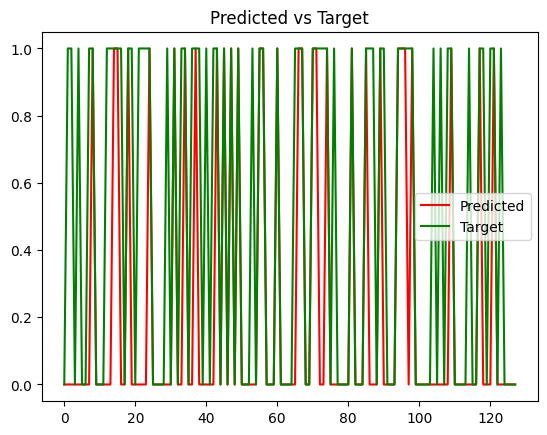

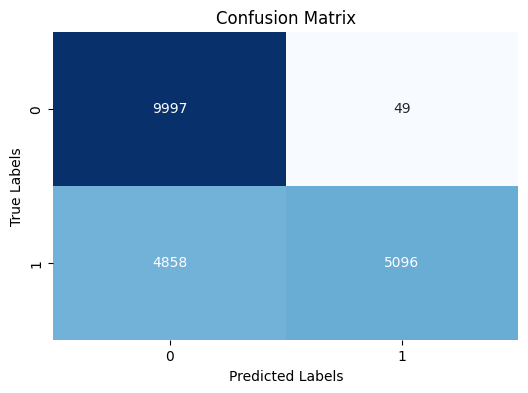

Precision: 0.9905
Recall: 0.5120
F1 Score: 0.6750
ROC-AUC Score: 0.8125


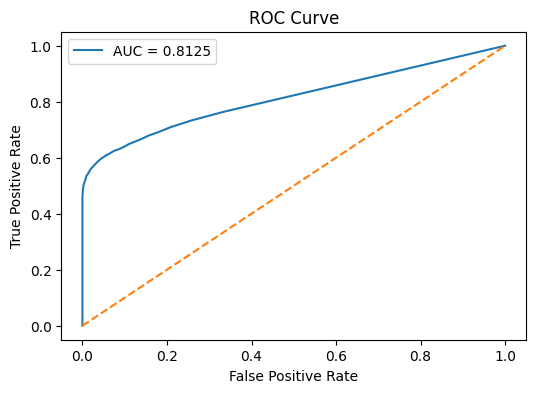

Total size: 20000, Correct_Prediction: 15093.0
Test Set Accuracy: 75.465%, acc : 75.48%
Average Test Loss: 39.7117


In [8]:
#Test the model with dataset5_Tau ------------------------------
total = 0
correct = 0
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
total_loss=0
i=0
all_preds=[]
all_targets=[]
accList=[]

with torch.no_grad():
  net.eval()
  for y_t, x_t, target_t, tau in test_loader:
    y_t = y_t.to(device).permute(1, 0, 2)
    x_t = x_t.to(device).permute(1, 0, 2)
    target_t = target_t.to(device)
    targets = target_t.to(device).float().unsqueeze(1)

    test_spk, test_mem = net(y_t, x_t)  # forward pass

    # Calculate loss
    batch_loss = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      batch_loss += loss(test_mem[step], targets)
    total_loss += batch_loss.item()

    # Calculate accuracy
    predicted = (test_spk.sum(dim=0) > num_steps / 2).float()
    acc = (predicted == targets).float().mean().item()
    correct += (predicted == targets).float().sum().item()
    total += targets.size(0)

    classOutput = test_spk.sum(dim=0)
    all_preds.extend(classOutput.squeeze().cpu().numpy())
    all_targets.extend(targets.squeeze().cpu().numpy())

    accList.append(acc)

    i+=1
    if i == 1:
      plt.plot(predicted, label='Predicted', color='red')
      plt.plot(targets, label='Target', color='green')
      plt.title('Predicted vs Target')
      plt.legend()
      plt.show()

# Compute Overall Test Metrics
all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)
calculate_metrics(all_targets, all_preds)


print(f"Total size: {total}, Correct_Prediction: {correct}")
print(f"Test Set Accuracy: {100 * correct / total}%, acc : {(sum(accList)/ len(accList)) * 100:.2f}%")
print(f"Average Test Loss: {total_loss / len(test_loader):.4f}")



